In [1]:
import torch
import tqdm
import numpy as np
from sklearn.manifold import TSNE
from torchvision import datasets, models, transforms
from vgg_face import *
from FAUDataset import *
import matplotlib.pyplot as plt

c:\Users\Yuan\anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Yuan\anaconda3\envs\pytorch\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] The specified procedure could not be found
  warn(f"Failed to load image Python extension: {e}")


In [2]:
data_transforms = {
        'test': transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            #transforms.Normalize([0.3873985 , 0.42637664, 0.53720075], [0.2046528 , 0.19909547, 0.19015081])
        ]),
    }

def set_parameter_requires_grad(model, feature_extracting):
    for param in model.parameters():
        param.requires_grad = False if feature_extracting else True

hidden_state_index = 0
num_classes = 10
batch_size = 32
checkpoint_path = 'C:/Users/Yuan/Downloads/models_r16/checkpoint_epoch49.pth'
dataset_root = 'C:/Users/Yuan/Datasets/FAU'
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')

model = VGG_16()
set_parameter_requires_grad(model, feature_extracting=False)
num_ftrs = model.fc8.in_features
model.fc8 = nn.Linear(num_ftrs, num_classes)
model.load_state_dict(torch.load(checkpoint_path), strict=False)

test_subjects = ['em10', 'ew10']
test_dataset = FAUDataset(dataset_root, subjects = test_subjects, transform=data_transforms['test'])
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model.to(device)
model.eval()
with torch.no_grad():
    running_pred_label = np.empty((0,0))
    for images, labels in test_loader:
        inputs = images.to(device)
        labels = labels.to(device)
        outputs = model.forward_thoughts(inputs, hidden_state_index).view(inputs.shape[0],-1)
        try:
            running_pred_label = np.concatenate((running_pred_label, np.concatenate([outputs.data.cpu().numpy(), labels.data.cpu().numpy()],axis=1)))
        except:
            running_pred_label = np.empty((0,outputs.shape[1]+10))
            running_pred_label = np.concatenate((running_pred_label, np.concatenate([outputs.data.cpu().numpy(), labels.data.cpu().numpy()],axis=1)))
    
    pred_test = running_pred_label[:,0:-10]
    label_test = running_pred_label[:,-10:]

In [3]:
X_embedded = TSNE(n_components=2, learning_rate='auto',
                 init='random', perplexity=3).fit_transform(pred_test)
img_index, label_index = np.nonzero(label_test[:, 1:])

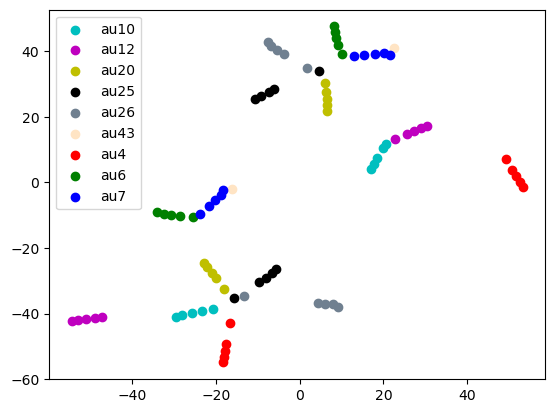

In [4]:
fig = plt.figure()
ax = fig.add_subplot(111)

labels_plt = {0:'au4', 1:'au6', 2:'au7', 3:'au10', 4:'au12', 5:'au20', 6:'au25', 7:'au26', 8:'au43'}
color_plt = {0:'r', 1:'g', 2:'b', 3:'c', 4:'m', 5:'y', 6:'k', 7:'slategrey', 8:'bisque'}
img_index, label_index = np.nonzero(label_test[:, 1:])

for i in range(X_embedded.shape[0]):
    try:
        ax.scatter(X_embedded[i,0], X_embedded[i,1], c=color_plt[label_index[list(img_index).index(i)]], label=labels_plt[label_index[list(img_index).index(i)]])
    except:
        pass
 
# build a legend using the labels we set previously
handles, labels = ax.get_legend_handles_labels()
handle_list, label_list = [], []
for handle, label in zip(handles, labels):
    if label not in label_list:
        handle_list.append(handle)
        label_list.append(label)
plt.legend(handle_list, label_list)
# finally, show the plot
plt.show()